In [1]:
import sys
sys.path.insert(1, '..')
from utils import *

%matplotlib inline

In [2]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']
util_datasets = config['util_datasets']
datasets = config['datasets']
colors = config['colors']
census_data = join(pwd, util_datasets, datasets['census-data'])

FIG_SAVE_DIR = join(pwd, 'figures')
RESULT_SAVE_DIR = join(pwd, 'results')

AREA_NAME = 'NYC'

In [3]:
census_quartiles, census_raw = get_census_attributes(census_data, list(nyc_fips2borough.keys()))

In [4]:
features = ['income-quartile', 'education-quartile', 'mean_time_to_work-quartile', 'white_population-quartile']
feature_labels = ['Income', 'Education', 'Commute Time', 'White Population']
feature_naming_dict = dict(zip(features, feature_labels))

quartiles = ['Bottom', 'Third', 'Second', 'Top']
qlabels = ['0% - 25%', '25% - 50%', '50% - 75%', '75% - 100%']
quartile_naming_dict = dict(zip(quartiles, qlabels))

In [5]:
hotspot_cbgs = pd.read_csv(join(pwd, util_datasets, 'nyc_case_rank.csv'))
bridge_cbgs = pd.read_csv(join(pwd, util_datasets, 'nyc_spreader_freq.csv'))

bridge_cbgs['rank'] = bridge_cbgs.freq.rank(pct=True)
bridge_cbgs['borough'] = bridge_cbgs.cbg.astype(str).str[:5].apply(lambda x: nyc_fips2borough[int(x)])

In [6]:
income = census_quartiles[['census_block_group', 'income-quartile']]
income = income[income.census_block_group.astype(str).str.startswith(str(nyc_borough2fips['Staten Island']))].dropna()
income['income-quartile'].value_counts(normalize=True)

Top       0.475694
Second    0.329861
Third     0.128472
Bottom    0.065972
Name: income-quartile, dtype: float64

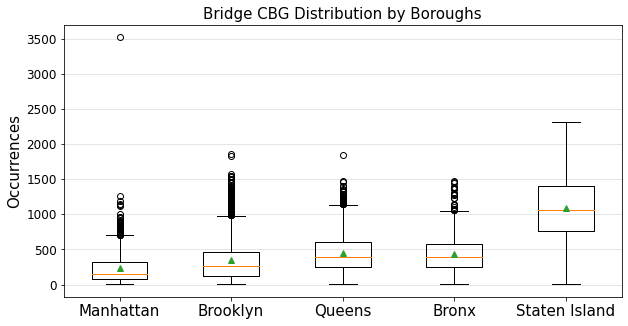

In [7]:
borough_sorted_by_median = bridge_cbgs.groupby('borough')['freq'].median().sort_values().index
sorted_occ_vecs = [bridge_cbgs[bridge_cbgs['borough'] == borough]['freq'].values for borough in borough_sorted_by_median]

fig, ax = plt.subplots(figsize=(10, 5))

#median_style = dict(linewidth=2, color='k')
ax.boxplot(sorted_occ_vecs, notch=False, vert=True, showmeans=True,
           meanline=False, labels=borough_sorted_by_median);
ax.grid(axis='y', alpha=0.4)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Occurrences', fontsize=15)
ax.set_title('Bridge CBG Distribution by Boroughs', fontsize=15)
fig.savefig(join(FIG_SAVE_DIR, 'bridge-boxplot.pdf'), bbox_inches='tight')

In [8]:
nyc_shp = gpd.read_file(join(pwd, 'util_datasets', 'NYC', 'NYC-cbgs.json'))
nyc_shp = nyc_shp[nyc_shp.BLKGRPCE != '0']

In [9]:
def plot_cbg_dist(cbgs, fig_title, fig_fname):
    fig = plt.figure(figsize=(20, 10))
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, wspace=0.01)
    
    qcolor = ['#7570b3', '#9ebcda', '#a1d99b', '#1b9e77']
    groups = [(r'75$^{th}$ Percentile', cbgs[cbgs['rank'] >= 0.75].cbg), (r'95$^{th}$ Percentile', cbgs[cbgs['rank'] >= 0.95].cbg)]
    
    for ind, group in enumerate(groups):        
        map_ax = fig.add_subplot(spec[ind, 0])
        map_ax.axis('off')
        
        bar_ax = fig.add_subplot(spec[ind, 1:])
        
        rect_ax = fig.add_subplot(spec[ind, :])
        rect_ax.axis('off')
        
        nyc_shp.plot(ax=map_ax, alpha=0.3, color='#b3cde3')
        nyc_shp[nyc_shp.GEOID.astype(np.int64).isin(group[1])].plot(ax=map_ax, color='#fc8d62')
        
        df = census_quartiles[census_quartiles.census_block_group.isin(group[1])].dropna()
        res_vals = []
        for f in features:
            res_vals.append(df[f].value_counts(normalize=True))
            
        pd.concat(res_vals, axis=1).T \
            .rename(columns=quartile_naming_dict, index=feature_naming_dict) \
            .plot.bar(ax=bar_ax, rot=0, width=.5, color=qcolor, legend=None)
        
        bar_ax.spines['right'].set_visible(False)
        bar_ax.spines['left'].set_visible(False)
        bar_ax.spines['top'].set_visible(False)
        bar_ax.spines['bottom'].set_visible(False)
        
        bar_ax.set_ylim([0, 0.5])
        bar_ax.tick_params(axis='x', labelsize=20)
        bar_ax.tick_params(axis='y', labelsize=15)
        bar_ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
        
        rect = mpatches.Rectangle((0.03, -0.11), width=0.97, height=1.15,
                                  fill=False, edgeColor='black', facecolor='black', linewidth=2, clip_on=False, linestyle='--')
        rect_ax.add_patch(rect)
        
        rect_ax.text(0.04, 0.9, group[0], fontsize=15, weight='bold', bbox=dict(edgecolor='black', fill=False, boxstyle='round'))
        
    patch_lst = []
    patch_labels = []
    for c, l in zip(qcolor, qlabels):
        patch_lst.append(mpatches.Patch(color=c))
        patch_labels.append(l)

    fig.legend(patch_lst,
                patch_labels,
                loc='center',
                ncol=len(patch_lst),
                bbox_to_anchor=(0.5, 0.95), 
                title_fontsize=20,
                fontsize=15,
                title='Quartiles', 
                edgecolor='white',
                facecolor='white'
            )
    
    fig.suptitle(fig_title, y=1.03, fontsize=30)
        
    plt.tight_layout()
    fig.savefig(join(FIG_SAVE_DIR, fig_fname), bbox_inches='tight', dpi=150)

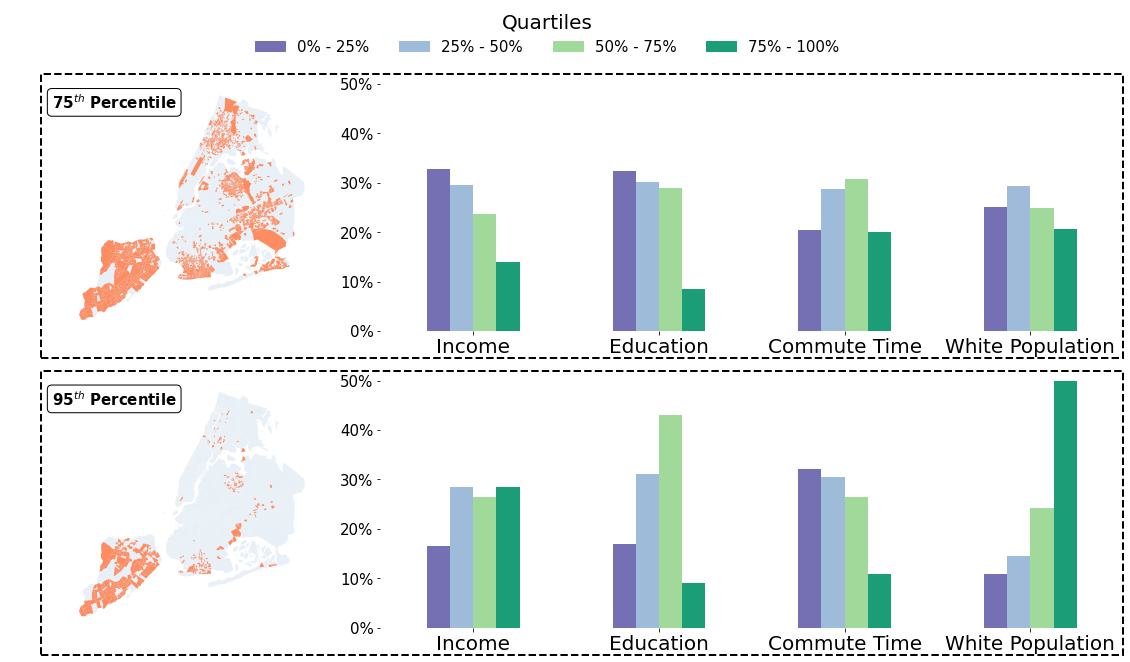

In [10]:
plot_cbg_dist(bridge_cbgs, '', 'bridge-demo-dist.pdf')

In [178]:
#plot_cbg_dist(hotspot_cbgs, 'Demographic Distribution of Hotspot CBGs', 'hotspot-demo-dist.pdf')